<H1> Clasificación de texto mediante ensemble </H1>

En este ejercicio vamos a ver una aproximación distinta al uso de modelos de clasificación introduciéndonos, a modo ejemplo, en el mundo del NLP.

Para ello, vamos a intentar clasificar tweets en si contienen información sobre desastres naturales o no lo contienen.

In [ ]:
!python -m nltk.downloader stopwords

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Importamos el conjunto de texto:

In [ ]:
df = pd.read_csv('nlp.csv')
df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

Comprobamos si las clases de los tweets están balanceadas:

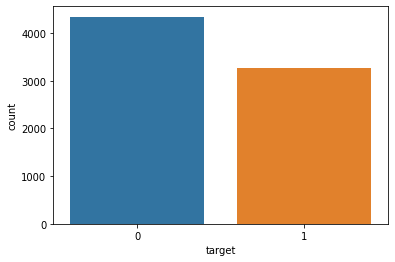

In [ ]:
ax = sns.countplot(x="target", data=df)

Se genera una función que transforma el dato del texto "bruto" a texto limpio y normalizado para el modelo:

In [ ]:
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    #convierte el texto a minúsculas
    text = text.lower()
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
    #elimina urls
    text = re.sub(r"http\S+", "",text)
    html=re.compile(r'<.*?>')
    #elimina tags html
    text = html.sub(r'',text)
    #elimina signos de puntuacion
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'')
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    #extrae lexemas de las palabras para normalizar
    text = [lemmatizer.lemmatize(word) for word in text]
    #elimina stopwords
    text = " ".join(text)
    #elimina otros caracteres (emojis, símbolos...)
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    return text

Se aplica la función para transformar los datos. A continuación se pueden ver las diferencias entre el texto limpio y el texto sucio:

In [ ]:
df['text_limpio'] = df['text'].apply(lambda x: clean_text(x))
df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                        text_limpio  
0       1         deed reason earthquake may allah forgive u  
1       1              forest fire near la ronge sask canada  
2       1  resident asked shelter place notified officer ...  
3       1  , people receive wildfire evacuation order cal...  
4       1  got sent photo ruby alaska smoke wildfire pour...

In [ ]:
sample_corpora = df['text_limpio'].iloc[:2].values
sample_corpora

array(['deed reason earthquake may allah forgive u',
       'forest fire near la ronge sask canada'], dtype=object)

Una forma clásica de codificar palabras es mediante Bag of Words (que la estudiaréis en NLP):

In [ ]:
count_vectorizer = CountVectorizer()
wm = count_vectorizer.fit_transform(sample_corpora)

doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
feat_names = count_vectorizer.get_feature_names()


sample_df = pd.DataFrame(data=wm.toarray(), index=doc_names,columns=feat_names)
sample_df

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


allah  canada  deed  earthquake  fire  forest  forgive  la  may  near  \
Doc0      1       0     1           1     0       0        1   0    1     0   
Doc1      0       1     0           0     1       1        0   1    0     1   

      reason  ronge  sask  
Doc0       1      0     0  
Doc1       0      1     1

Vamos ahora a dividir el conjunto de datos en train y test y en variable predictora y objetivo

In [ ]:
X = df['text_limpio'].values
y = df['target'].values
X_train, X_test , y_train, y_test = train_test_split(X,y,
                                                     test_size=0.2,
                                                     random_state=123)

Otra forma de codificar el texto, como evolución del algoritmo Bag of Words es el modelo TF-IDF (de nuevo, se estudiará en NLP, esto es únicamente un pequeño avance):

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)

tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

Vamos ahora a entrenar un modelo con las codificaciones de entrenamiento y la variable objetivo:

In [ ]:
classifier = RandomForestClassifier()

classifier.fit(tfidf_train_vectors,y_train)

RandomForestClassifier()

**PREDICCIONES SOBRE TRAIN**

In [ ]:
y_pred_train = classifier.predict(tfidf_train_vectors)

Cálculo de métricas en train:

In [ ]:
accuracy_score(y_train,y_pred_train)

0.9963875205254515

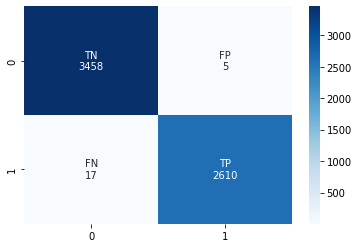

In [ ]:
cnf_matrix = confusion_matrix(y_train,y_pred_train)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

**PREDICCIONES SOBRE TEST**

In [ ]:
y_pred_test = classifier.predict(tfidf_test_vectors)

Cálculo de métricas sobre test:

In [ ]:
accuracy_score(y_test,y_pred_test)

0.7918581746552856

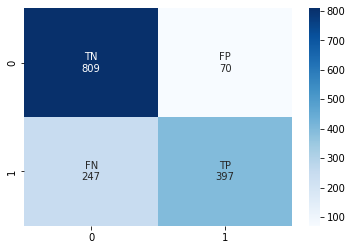

In [ ]:
cnf_matrix = confusion_matrix(y_test,y_pred_test)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');